# <h1 style="text-align: center;">Optimal Control of TCLab using a Gaussian process regression embedded in Pyomo</h1>

<p style="text-align: center;">Alex Dowling<sup>1,a</sup>, Jacob P. Krell<sup>2</sup>, David S. Mebane<sup>2,b</sup>, Kyla Jones<sup>1</sup></p>

<p style="text-align: center;"><sup>1</sup>Department of Chemical and Biomolecular Engineering, University of Notre Dame, Notre Dame, IN 46556, USA <br>
<sup>2</sup>Department of Mechanical and Aerospace Engineering, West Virginia University, Morgantown, WV, 26506-6106, USA</p>

<sup>a</sup>adowling@nd.edu <br>
<sup>b</sup>david.mebane@mail.wvu.edu

---

## Introduction

TCLab has been modeled as a two state model, i.e., two-state ODE, predicting temperatures $T_{H,1}$ and $T_{S,1}$. However, a Gaussian process (GP) trained with measurements of $T_{S,1}$ may improve prediction accuracy. If the GP is trained on either $T_{S,1}$ or its numerically-calculated time derivative $\Delta T_{S,1}$, the GP may be plugged into the ODE to obtain $T_{H,1}$ predictions. The residual, i.e., the difference between ODE predictions and experimental measurements of $T_{S,1}$, may also be modeled with a GP to more accurately adjust predictions. These three methods are explored as follows.

### 1. Two-State Model

This is the original two-state ODE that will serve as a reference for comparison. The GP methods must outperform this benchmark.

$$\begin{align} 
\tag{1a} C^H_p\frac{dT_{H,1}}{dt} & = U_a(T_{amb} - T_{H,1}) + U_b(T_{S,1} - T_{H,1}) + \alpha P_1u_1 \\ 
\tag{1b} C^S_p\frac{dT_{S,1}}{dt} & = U_b(T_{H,1} - T_{S,1}) 
\end{align}$$

### 2. GP of $T_{S,1}$

Most simple would be to train the GP model $\mathbf{GP}_{T_{S,1}}$ on $\{T_{S,1} |\ t\}$; however, more physically true would be $\{T_{S,1} |\ t,\ Q_1,\ Q_2\}$.

#### 2.1. Univariate GP

A single-state ODE is formed.

$$\tag{2.1} C^H_p\frac{dT_{H,1}}{dt} = U_a(T_{amb} - T_{H,1}) + U_b(\mathbf{GP}_{T_{S,1}}(t) - T_{H,1}) + \alpha P_1u_1$$

#### 2.2. Multivariate GP

##### 2.2.1. Direct Implementation

A single-state ODE is formed.

$$\tag{2.2.1} C^H_p\frac{dT_{H,1}}{dt} = U_a(T_{amb} - T_{H,1}) + U_b(\mathbf{GP}_{T_{S,1}}(t, Q_1(t), Q_2(t)) - T_{H,1}) + \alpha P_1u_1$$

##### 2.2.2. Derivative via Chain Rule

A two-state ODE is formed. See Equation $(1a)$ for Equation $(2.2.2a)$.

$$\tag{2.2.2b} \frac{dT_{S,1}}{dt} = \frac{\partial \mathbf{GP}_{T_{S,1}}}{\partial t} + \left(\frac{\partial \mathbf{GP}_{T_{S,1}}}{\partial Q_1}\right) \left(\frac{dQ_1}{dt}\right) + \left(\frac{\partial \mathbf{GP}_{T_{S,1}}}{\partial Q_2}\right) \left(\frac{dQ_2}{dt}\right) \text{ at } t$$

### 3. GP of $\Delta T_{S,1}$

Applying a smoothing function to $T_{S,1}$ measurements before taking the numerical gradient to arrive at $\Delta T_{S,1}$, $\mathbf{GP}_{\Delta T_{S,1}}$ may be trained on the simple $\{\Delta T_{S,1}\ |\ t\}$ or multivariate $\{\Delta T_{S,1}\ |\ t,\ Q_1,\ Q_2\}$.

#### 3.1. Univariate GP

A two-state ODE is formed. See Equation $(1a)$ for Equation $(3.1a)$.

$$\tag{3.1b} \frac{dT_{S,1}}{dt} = \mathbf{GP}_{\Delta T_{S,1}}(t)$$

#### 3.2. Multivariate GP

A two-state ODE is formed. See Equation $(1a)$ for Equation $(3.2a)$.

$$\tag{3.2b} \frac{dT_{S,1}}{dt} = \mathbf{GP}_{\Delta T_{S,1}}(t, Q_1(t), Q_2(t))$$

### 4. Residual

The residual of any of the above predictions may be modeled as a GP, $\mathbf{GP}_\text{res}$. However, constraining the overall method to one GP, only the residual of [Two-State Model](#1-two-state-model) will be trained. The training set is formed by $\{\left(T_{S,1}\right)_\text{obs} - \left(T_{S,1}\right)_\text{ODE}\ |\ t\}$ where $\text{obs}$ is an observation, i.e., experimental measurement, and $\text{ODE}$ is a prediction from Equation $(1)$. With the residual modeled, the prediction is enhanced with the following.

$$\tag{4} T_{S,1} = \left(T_{S,1}\right)_\text{ODE} + \mathbf{GP}_\text{res}$$

---

## Implementation

Import modules:

In [26]:
from FoKL import FoKLRoutines
# from FoKL.fokl_to_pyomo import fokl_to_pyomo
import os
dir = os.path.abspath('')  # directory of notebook
# -----------------------------------------------------------------------
# UNCOMMENT IF USING LOCAL FOKL PACKAGE:
import sys
sys.path.append(os.path.join(dir, '..', '..'))  # package directory
from src.FoKL import FoKLRoutines
from src.FoKL.fokl_to_pyomo import fokl_to_pyomo
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

Systems-level parameters:

In [27]:
filename = "tclab_sine_test.csv"
tmax = None  # maximum time for normalization bounds (increases ability to extrapolate GP models); 'None' uses data's max

Load and parse data:

In [43]:
data = pd.read_csv(os.path.join(dir, filename))

Q1_obs = data["Q1"].values
Q2_obs = data["Q2"].values
TS1_obs = data["T1"].values
t_obs = data["Time"].values

Smooth $T_{S,1}$ to obtain $\Delta T_{S,1}$:

In [ ]:
# TS1_smooth = 
# dTS1 = gradient(TS1_smooth)

Train GPs:

/home/jacobpatrick/ESMS/support/FoKL-GPy-tclab_v4/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:271: UserWarning: 'data' was auto-converted to numpy. Convert manually for assured accuracy.
  warnings.warn("'data' was auto-converted to numpy. Convert manually for assured accuracy.",
/home/jacobpatrick/ESMS/support/FoKL-GPy-tclab_v4/examples/pyomo_tclab/../../src/FoKL/FoKLRoutines.py:290: UserWarning: 'inputs' was transposed. Ignore if more datapoints than input variables, else set 'AutoTranspose=False' to disable.
  warnings.warn("'inputs' was transposed. Ignore if more datapoints than input variables, else set "


[1, 3592.127247512837]
[2, 3587.245251431803]
[2, 2325.6195698812176]
[3, 2307.576809156444]
[3, 574.1060402705099]
[4, 580.4618338175072]
[4, 546.3840207701105]
[4, -324.8212772396926]
[5, -324.8212772396926]
[5, -324.8212772396926]
[5, -377.7272626032877]
[6, -377.7272626032877]
[6, -377.7272626032877]
[6, -384.6794778944836]
[6, -387.9020683247104]
[7, -387.9020683247104]
[7, -387.9020683247104]
[7, -383.9482776626703]


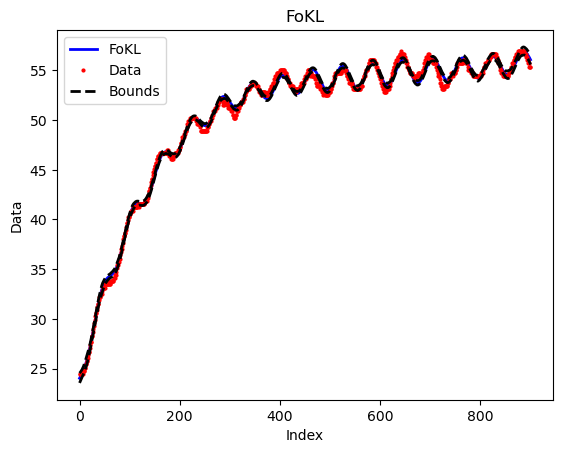

(array([24.02903701, 24.13170224, 24.23477368, 24.33448283, 24.43295111,
        24.53033028, 24.64566904, 24.76005189, 24.87356057, 25.00496937,
        25.1336243 , 25.28374177, 25.43106417, 25.59604086, 25.76008178,
        25.94183272, 26.12272281, 26.32155602, 26.51968947, 26.73617314,
        26.95218986, 27.18709806, 27.42180568, 27.67600514, 27.93024283,
        28.20452261, 28.45873187, 28.73307383, 29.00732261, 29.28133727,
        29.55327349, 29.84701764, 30.12119342, 30.39286208, 30.66358817,
        30.93323953, 31.18134682, 31.42668895, 31.67415957, 31.89868281,
        32.12212698, 32.32456904, 32.52604746, 32.70674157, 32.88654516,
        33.04564107, 33.20384422, 33.34124376, 33.47766364, 33.59146477,
        33.70722878, 33.79997752, 33.89139563, 33.95937743, 34.02737968,
        34.07453587, 34.13964996, 34.18238523, 34.22378992, 34.26399607,
        34.28185583, 34.32005476, 34.35746658, 34.39421763, 34.43043288,
        34.46623591, 34.52268298, 34.57871637, 34.6

In [42]:
# Initialize each GP with FoKL class:
GPs = {"list": ["TS1", "TS1_multi" , "dTS1", "dTS1_multi", "res"]}  # names of GPs
for GP in GPs["list"]:
    GPs.update({GP: FoKLRoutines.FoKL(kernel=1)})

# Convert system parameter 'tmax' to percent:
if tmax is None:
    tmax_p = 0
else:
    tmax_p = (tmax - t_obs[-1]) / (t_obs[-1] - t_obs[0])

# Train GPs (except 'res'):
# GPs["TS1"].fit(data["Time"], data["T1"], clean=True, pillow=[[0, tmax_p]])
GPs["TS1_multi"].fit([t_obs, Q1_obs], TS1_obs, clean=True, pillow=[[0, tmax_p], [0, 0]])
# GPs["dTS1"].fit(t, dTS1, clean=True, pillow=[[0, tmax_p]])
# _ = GPs["dTS1_multi"].fit([t, Q1, Q2], dTS1, clean=True, pillow=[[0, tmax_p], [0, 0], [0, 0]])

Known heater power analytic expressions:

In [ ]:
Q1_func = lambda _t: 50 * np.sin(30 * np.pi * _t / t[-1]) + 50
Q2_func = lambda _t: 0

ODE parameters:

In [ ]:
alpha = 0.00016         # watts / (units P1 * percent U1)
P1 = 200                # P1 units
T_amb = TS1[0]          # ambient temperature

IC2 = [T_amb, T_amb]    # initial condition of states [TH1, TS1]
IC1 = IC2[0]            # initial condition of state [TH1]
CpH =  7.006            # J/degC
CpS = 0.01              # J/degC
Ua =  0.051             # W/degC
Ub =  0.001             # W/degC

Define equations:

In [ ]:
def eq_1a(TH1, TS1, Q1):
    return (Ua * (T_amb - TH1) + Ub * (TS1 - TH1) + alpha * P1 * Q1) / CpH

Define ODEs:

In [ ]:
def ode_1(t, states):
    TH1, TS1 = states
    dTH1 = eq_1a(TH1, TS1, Q1_func(t))
    dTS1 = Ub * (TH1 - TS1) / CpS
    return [dTH1, dTS1]

def ode_2_1(t, states):
    TH1 = states
    TS1 = GPs["TS1"].evaluate(t)
    dTH1 = eq_1a(TH1, TS1)
    return [dTH1]

# def ode_2_2(t, states):
#     return

odes = {'1': ode_1, '2.1': ode_2_1}

Solve ODEs:

In [25]:
cases = ['1', '2.1']
cases_uni = ['2.1']  # univariate ODEs
# ------------------------------------

soln = {}  # ODE solutions
pred = {}  # dataframe of predictions
for case in cases:
    
    if case in cases_uni:  # if single-state model
        _is_uni = True  # case is univariate
        IC = IC1
    else:  # if two-state model
        _is_uni = False  # case is not univariate
        IC = IC2

    soln_i = solve_ivp(odes[case], [t[0], t[-1]], IC, t_eval=t)  # solve ODE
    
    pred_i = pd.DataFrame()
    pred_i["TH1"] = soln_i.y[0]
    if _is_uni is False:  # if two-state model
        pred_i["TS1"] = soln_i.y[1]
        
    soln.update({case, soln_i})
    pred.update({case, pred_i})

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.